In [1]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana as pdn
import pickle as pkl
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories
for d in ["data", "logs", "models", "networks"]:
    if not os.path.isdir(d):
        os.mkdir(d)

## Trips

In [119]:
# Bring the trips
trips = pd.read_csv(f"data/trips2.csv")

In [120]:
# Filtrar

trips = trips[trips['Mun_Ori'] != trips['Mun_Des']]

# trips = trips[trips['Proposito'] == 'Trabajo']
trips = trips[(trips['Act_Ori'].isin(['Trabajo habitual', 'Asuntos trabajo'])) | (trips['Act_Des'].isin(['Trabajo habitual', 'Asuntos trabajo']))]

trips = trips.reset_index(drop=True)

In [121]:
# Changes primary modes to a different model: auto or green_modes

trips = trips[trips['Modo'] != 'Otros']

# 5 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "Autobus"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "Autobus"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "Autobus"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "Tren"
# trips.loc[trips.Modo=="RENFE","Modo"] = "Tren"

# 2 MODOS, coche y green

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "Green"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "Green"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "Green"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "Green"
# trips.loc[trips.Modo=="RENFE","Modo"] = "Green"
# trips.loc[trips.Modo=="Andando","Modo"] = "Green"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Green"

# 2 MODOS, TP y coche

trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús urbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "TP"
trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "TP"
trips.loc[trips.Modo=="RENFE","Modo"] = "TP"
trips = trips[trips['Modo'] != 'Andando']
trips = trips[trips['Modo'] != 'Bicicleta']

# 3 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "PT"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "PT"
# trips.loc[trips.Modo=="RENFE","Modo"] = "PT"
# trips.loc[trips.Modo=="Andando","Modo"] = "Active modes"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Active modes"

# 4 MODOS

# trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
# trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
# trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
# trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
# trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús urbano","Modo"] = "PT"
# trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "PT"
# trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "PT"
# trips.loc[trips.Modo=="RENFE","Modo"] = "PT"
# trips.loc[trips.Modo=="Andando","Modo"] = "Andando"
# trips.loc[trips.Modo=="Bicicleta","Modo"] = "Bicicleta"

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.Modo==label].shape[0]:,}" for label in trips.Modo.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Coche: 2,071
TP: 411
Total: 2,482


In [122]:
# Asignar numero a Municipio, para no tener problemas en el encoding. Hay pueblos de test que igual no hay en train entonces no lo puede codificar.

pueblos = pd.read_excel(f"data/pueblos_gipuzkoa.xlsx")
eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
       'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
       'Densidad (hab./kmÂ²)', 'Incluido']
pueblos = pueblos.drop(columns=eliminar)

trips = pd.merge(trips, pueblos, left_on='Municipio', right_on='Town')
trips = trips.drop(columns=['Municipio', 'Town'])
trips.rename(columns={'Código': 'Municipio'}, inplace=True)


# Split the data - TRAIN & TEST

In [123]:
# Determinar el tamaño del 80% y el 20%
percent_80 = int(len(trips) * 0.8)
percent_20 = len(trips) - percent_80

# Obtener índices aleatorios para el 80%
indices_80 = np.random.choice(trips.index, percent_80, replace=False)

# Crear dos nuevos DataFrames: uno para el 80% y otro para el 20%
trips_train = trips.loc[indices_80]
trips_test = trips.drop(indices_80)

# Expand the Data

In [124]:
# Expandir los trips, hacer que cada trayecto sea una fila

# TRAIN

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips_train.iterrows():
    valores_columnas = row[trips_train.columns]
    repeticiones = row['elev']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips_train = pd.DataFrame(nuevas_filas, columns=trips_train.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips_train = trips_train.drop(columns=["elev"])

# Mezclo las filas de manera aleatoria
trips_train = trips_train.sample(frac=1).reset_index(drop=True)

#Expandir los trips, hacer que cada trayecto sea una fila

# TEST

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips_test.iterrows():
    valores_columnas = row[trips_test.columns]
    repeticiones = row['elev']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips_test = pd.DataFrame(nuevas_filas, columns=trips_test.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips_test = trips_test.drop(columns=["elev"])

# Mezclo las filas de manera aleatoria
trips_test = trips_test.sample(frac=1).reset_index(drop=True)

# Change modes of transportation

In [125]:
# Reducir el numero de trips en coche a la suma del resto de modos.

# Numero de green trips
condicion = trips_train['Modo'] != 'Coche'
green_trips = condicion.sum()

condicion = trips_train['Modo'] == 'Coche'
coche_trips = condicion.sum()
eliminar=coche_trips-green_trips

#eliminar=len(trips['MODO_INFORME']=='Coche')-green_trips

# Escoger aleatoriamente ese numero de trips de todos los del coche

# Filtrar las filas que cumplen con el modo de transporte "coche"
coche_rows = trips_train[trips_train['Modo'] == 'Coche']

# Seleccionar aleatoriamente X filas del conjunto de filas "coche_rows"
muestras_aleatorias = coche_rows.sample(n=eliminar)

# Eliminar las filas que no fueron seleccionadas aleatoriamente
trips_train = trips_train[~trips_train.index.isin(muestras_aleatorias.index)]

trips_train=trips_train.reset_index(drop=True)

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips_train[trips_train.Modo==label].shape[0]:,}" for label in trips_train.Modo.unique()]:
    print(p)
print(f"Total: {trips_train.shape[0]:,}")

TP: 73,521
Coche: 73,521
Total: 147,042


In [126]:
# Filtrar
trips_train = trips_train.drop(columns=['Unnamed: 0'])
trips_train = trips_train.reset_index(drop=True)

trips_test = trips_test.drop(columns=['Unnamed: 0'])
trips_test = trips_test.reset_index(drop=True)

# Asignar Lat y Long origen y destino

Bring the buildings

In [127]:
# Leer el archivo Shapefile
gdf = gpd.read_file(f"data/ERAIKINAK_EDIFICIOS/buildings.shp")

# Pasar las geometrias de los edificios de sistema UTM a sistema decimal de coordenadas
crs_objetivo = 'EPSG:4326'  # WGS84
gdf = gdf.to_crs(crs_objetivo)

# Crear una columna que contiene el centroide del edificio, para obtener un punto
gdf['Centroide'] = gdf['geometry'].centroid
gdf.columns

C:\Users\iazka\AppData\Local\Temp\ipykernel_23980\1237833868.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['Centroide'] = gdf['geometry'].centroid


Index(['Town', 'Edificabil', 'Solar', 'Vivienda', 'Trastero', 'Garaje Cer',
       'Agropecuar', 'Local Come', 'Industrial', 'Almacen', 'Deportivo',
       'Cultural', 'Educativo', 'Oficina', 'Hosteleria', 'Obras Urba',
       'Altura men', 'Terraza', 'Accesos y', 'Jardin', 'Sanidad', 'Deposito',
       'Duplex', 'Plaza Park', 'Religioso', 'Espectacul', 'geometry',
       'Centroide'],
      dtype='object')

In [128]:
asignaciones = {
    'Otra vivienda': ['Vivienda', 'Duplex'],
    'Centro estudios': ['Educativo'],
    'Compras doméstico-familiares': ['Local Come'],
    'Asuntos trabajo': ['Oficina'],
    'Trabajo habitual': ['Oficina'],
    'Ocio, cultura, deporte': ['Deportivo', 'Cultural', 'Hosteleria', 'Terraza', 'Jardin', 'Religioso', 'Espectacul'],
    'Acompañamiento de ayuda, cuidado': ['Local Come'],
    'Residencia Habitual': ['Vivienda', 'Duplex'],
    'Médico / Hospital': ['Sanidad'],
    'Gestiones personales': ['Local Come'],
    'Compras personales': ['Local Come'],
    'Otras actividades': ['Local Come'],
    'Gestiones doméstico-familiares': ['Local Come'],

}

# Encontrar la longitud máxima de todas las listas
max_length = max(len(lista) for lista in asignaciones.values())

# Rellenar las listas con valores NaN para que tengan la misma longitud
for columna in asignaciones:
    asignaciones[columna] += [np.nan] * (max_length - len(asignaciones[columna]))

# Crear el DataFrame a partir del diccionario
asignaciones = pd.DataFrame(asignaciones)

In [129]:
# Función para obtener la lista de una columna específica
def obtener_lista_por_columna(df, columna):
    if columna in df.columns:
        l = df[columna].tolist()
        l = [x for x in l if isinstance(x, str)]
        return l
    else:
        return []

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_origen(row):
    matching_rows = gdf[gdf['Town'] == row['Mun_Ori']] # Lista con todos las RC de ese pueblo
    matching_usos = obtener_lista_por_columna(asignaciones, row['Act_Ori']) # Lista con los posibles usos de esa actividad
    matching_rows = matching_rows[(matching_rows[matching_usos] != 0).any(axis=1)] # De las RC del pueblo, coge solo las que no tienen nulo el m2, mínimo alguno de los usos de suelo asignado a esa actividad origen. Esto es, si hay alguna RC que no tiene ningún uso de suelo de interés para esa actividad, se elimina.

    # Genero una matriz auxiliar quitando Town, geometry y Centroide para hacer los calculos
    auxiliar = matching_rows.drop(columns=['Town', 'geometry', 'Centroide'])
    # Hasta este punto, tengo un gdf con las RC de pueblo adecuado y con todas las RC que hacen match con esa actividad, esto es, no hay ninguna fila que tenga todos los m2 nulos.
    # El próximo paso es asignar una fila (RC), y para ello escojo por probabilidad una ubicación exacta de la matriz (tanto RC como uso de suelo) y selecciono esa fila (RC) para pasarle

    if not matching_rows.empty:
        probabilidades = auxiliar.values / auxiliar.values.sum() # Normalizar los valores para representar probabilidades
        # Generar números aleatorios para seleccionar fila y columna
        fila_seleccionada = random.choices(range(auxiliar.shape[0]), weights=probabilidades.sum(axis=1))[0]
        columna_seleccionada = random.choices(range(auxiliar.shape[1]), weights=probabilidades[fila_seleccionada])[0]
        valor_seleccionado = auxiliar.iloc[fila_seleccionada, columna_seleccionada]         # Obtener el valor seleccionado, fila y columna
        fila = matching_rows.index[fila_seleccionada] # Devolver la fila, la columna y el valor seleccionado
        return gdf.loc[fila, 'Centroide']
    else:
        return None

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_destino(row):
    matching_rows = gdf[gdf['Town'] == row['Mun_Des']] # Lista con todos las RC de ese pueblo
    matching_usos = obtener_lista_por_columna(asignaciones, row['Act_Des']) # Lista con los posibles usos de esa actividad
    matching_rows = matching_rows[(matching_rows[matching_usos] != 0).any(axis=1)] # De las RC del pueblo, coge solo las que no tienen nulo el m2, mínimo alguno de los usos de suelo asignado a esa actividad origen. Esto es, si hay alguna RC que no tiene ningún uso de suelo de interés para esa actividad, se elimina.

    # Genero una matriz auxiliar quitando Town, geometry y Centroide para hacer los calculos
    auxiliar = matching_rows.drop(columns=['Town', 'geometry', 'Centroide'])
    # Hasta este punto, tengo un gdf con las RC de pueblo adecuado y con todas las RC que hacen match con esa actividad, esto es, no hay ninguna fila que tenga todos los m2 nulos.
    # El próximo paso es asignar una fila (RC), y para ello escojo por probabilidad una ubicación exacta de la matriz (tanto RC como uso de suelo) y selecciono esa fila (RC) para pasarle

    if not matching_rows.empty:
        probabilidades = auxiliar.values / auxiliar.values.sum() # Normalizar los valores para representar probabilidades
        # Generar números aleatorios para seleccionar fila y columna
        fila_seleccionada = random.choices(range(auxiliar.shape[0]), weights=probabilidades.sum(axis=1))[0]
        columna_seleccionada = random.choices(range(auxiliar.shape[1]), weights=probabilidades[fila_seleccionada])[0]
        valor_seleccionado = auxiliar.iloc[fila_seleccionada, columna_seleccionada]         # Obtener el valor seleccionado, fila y columna
        fila = matching_rows.index[fila_seleccionada] # Devolver la fila, la columna y el valor seleccionado
        return gdf.loc[fila, 'Centroide']
    else:
        return None


# Aplicar la función a trips para crear la columna Edif_ORIGEN y Edif_DESTINO

# TRAIN

trips_train['Edif_Ori'] = trips_train.apply(asignar_coord_origen, axis=1)
trips_train['Edif_Des'] = trips_train.apply(asignar_coord_destino, axis=1)

# TEST

trips_test['Edif_Ori'] = trips_test.apply(asignar_coord_origen, axis=1)
trips_test['Edif_Des'] = trips_test.apply(asignar_coord_destino, axis=1)

In [130]:
# Save

trips_train.to_csv(f"data/Gipuzkoa_MT2_extended_train.csv")
trips_test.to_csv(f"data/Gipuzkoa_MT2_extended_test.csv")

In [131]:
# Pasa de un punto en formato WKT a dos columnas con LONG y LAT

from shapely import wkt
from shapely.geometry import Point

def extraer_longitud(punto):
    return punto.x

def extraer_latitud(punto):
    return punto.y

# from shapely import wkt
# from shapely.geometry import Point

# def extraer_longitud(punto_wkt):
#     punto = wkt.loads(punto_wkt)
#     return punto.x

# def extraer_latitud(punto_wkt):
#     punto = wkt.loads(punto_wkt)
#     return punto.y

# TRAIN

trips_train['O_long'] = trips_train['Edif_Ori'].apply(extraer_longitud)
trips_train['O_lat'] = trips_train['Edif_Ori'].apply(extraer_latitud)
trips_train['D_long'] = trips_train['Edif_Des'].apply(extraer_longitud)
trips_train['D_lat'] = trips_train['Edif_Des'].apply(extraer_latitud)

trips_train = trips_train.drop(columns=["Edif_Ori","Edif_Des"])
trips_train = trips_train.reset_index(drop=True)

# TEST

trips_test['O_long'] = trips_test['Edif_Ori'].apply(extraer_longitud)
trips_test['O_lat'] = trips_test['Edif_Ori'].apply(extraer_latitud)
trips_test['D_long'] = trips_test['Edif_Des'].apply(extraer_longitud)
trips_test['D_lat'] = trips_test['Edif_Des'].apply(extraer_latitud)

trips_test = trips_test.drop(columns=["Edif_Ori","Edif_Des"])
trips_test = trips_test.reset_index(drop=True)

In [133]:
trips_test

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Actividad,crnt_tur,crnt_mot,crnt_otr,Income,Municipio,O_long,O_lat,D_long,D_lat
0,20,20,Tolosaldea,Donostialdea,Tolosa,Lasarte-Oria,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,1,2,2,27963.510,71,-2.074307,43.137441,-2.020355,43.268374
1,20,20,Goierri,Goierri,Legazpi,Zumarraga,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,1,2,2,21253.950,51,-2.336995,43.053924,-2.316473,43.089248
2,20,20,Donostialdea,Donostialdea,Errenteria,Donostia/San Sebastian,Residencia Habitual,Asuntos trabajo,Trabajo,Coche,...,1,1,2,2,23674.810,67,-1.899408,43.311497,-1.980285,43.309363
3,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Errenteria,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,1,2,2,20299.445,67,-2.022784,43.301730,-1.895637,43.311476
4,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,1,2,2,22958.420,36,-1.807184,43.344079,-1.816789,43.330403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111592,20,20,Donostialdea,Urola Kosta,Pasaia,Zarautz,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,1,2,2,25707.160,79,-1.918149,43.320613,-2.166877,43.280650
111593,20,20,Urola Kosta,Urola Kosta,Azpeitia,Azkoitia,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,1,1,2,2,28065.310,18,-2.273223,43.133629,-2.330336,43.176306
111594,20,20,Donostialdea,Donostialdea,Pasaia,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,1,1,2,2,22167.900,64,-1.927034,43.323955,-2.022784,43.301730
111595,20,20,Donostialdea,Donostialdea,Hernani,Donostia/San Sebastian,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,1,1,2,2,28664.060,69,-1.986740,43.275951,-1.972898,43.320224


In [134]:
# Save
trips_train.to_csv(f"data/Gipuzkoa_MT2_extended_train.csv")
trips_test.to_csv(f"data/Gipuzkoa_MT2_extended_test.csv")

In [2]:
# Bring
trips_train = pd.read_csv(f"data/Gipuzkoa_MT2_extended_train.csv",index_col=0)

In [3]:
# Bring
trips_test = pd.read_csv(f"data/Gipuzkoa_MT2_extended_test.csv",index_col=0)

# Add Travel Time

In [4]:
# Crea un diccionario, donde los valores son None y las claves son esas cuatro

networks = dict.fromkeys({
 "walk",
 "transit",
 "train",
 "drive",
})

# Asigna al valor correspondiente en el diccionario networks un objeto de red creado mediante el método from_hdf5() de la clase Network del módulo pdn.network. 
# Los creados con los codigos anteriores

for k in networks:
    print(k)
    networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')

train
transit
drive
walk


In [5]:
# Asignar tt a cada modo de transporte para cada trip

# Para cada trip, asigna la distancia mas corta que se puede hacer con Network (walk, drive, transit) con shortest_path_lengths
# Coge lat,long de origen y destino de cada trip. A ese origen y destino le asigna el nodo del Network correspondiente más cercano con get_node_ids
# Le pasa esos nodos del Network correspondiente a shortest_path_lengths, y este calcula la distancia entre esos nodos

for k in networks:
    if k != 'drive':
        trips_train[f"{k}_tt"] = networks[k].shortest_path_lengths(
            networks[k].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks[k].get_node_ids(trips_train.D_long,trips_train.D_lat)
            )

trips_train["walk_tt"] = trips_train["walk_tt"] / 80.46 # Pasar de distancia (m) a minutos con un ritmo de 3 mp/h = 80.46 m/min.

trips_train["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks['drive'].get_node_ids(trips_train.D_long,trips_train.D_lat),
            imp_name='drive_time_s'
            )

trips_train["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks['drive'].get_node_ids(trips_train.D_long,trips_train.D_lat),
            imp_name='distance'
            )

trips_train["drive_tt"] = trips_train["drive_tt"] / 60 # Para pasar a minutos
trips_train["bike_tt"] =  networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_train.O_long,trips_train.O_lat),
            networks['drive'].get_node_ids(trips_train.D_long,trips_train.D_lat),
            imp_name='distance'
            )
trips_train["bike_tt"] = trips_train["bike_tt"] * 60 / (1000*13.07)  # 13.07 km/h = 13.07*1000/60 m/min

# trips_train['pt_tt'] = trips_train[['train_tt', 'transit_tt']].min(axis=1)
# trips_train = trips_train.drop(columns=['train_tt', 'transit_tt'])

# Eliminar andando y bike

trips_train = trips_train.drop(columns=['walk_tt', 'bike_tt'])
trips_train

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(45389, 13285), (80032, 6509), (46160, 80032), (82464, 45373), (51426, 80032), (80032, 11775), (21993, 91291), (80032, 53655), (85, 80032), (80032, 68960), (80653, 80032), (80849, 80032), (80032, 48334), (45376, 65377), (80032, 76598), (39575, 80032), (22824, 80032), (15825, 1803), (15825, 74513), (80019, 66953), (80032, 7310), (1226, 91291), (80032, 58773), (10468, 80032), (80032, 55411), (80032, 16698), (80032, 77936), (14757, 80032), (21816, 80032), (80032, 3001), (80032, 85), (80032, 25532), (80032, 25126), (3328, 80032), (22164, 80032), (80032, 3134), (20349, 44434), (80032, 21196), (45528, 45381), (82547, 20349), (16490, 80032), (8106, 80032), (80051, 2559), (8312, 80032), (85, 80032), (45369, 42954), (55095, 80032), (22928, 80032), (3274,

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Income,Municipio,O_long,O_lat,D_long,D_lat,train_tt,transit_tt,drive_tt,distance
0,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Pasaia,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,20293.950,64,-2.004190,43.312481,-1.918971,43.313684,49.379,31.417,10.234183,7996.575
1,20,20,Debabarrena,Debabarrena,Eibar,Elgoibar,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,24570.385,30,-2.469554,43.183977,-2.404688,43.216960,38.770,28.363,7.490967,7844.406
2,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Errenteria,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,21338.350,67,-1.984329,43.319607,-1.910085,43.316631,30.052,20.349,7.970000,6409.071
3,20,20,Donostialdea,Debagoiena,Donostia/San Sebastian,Oñati,Asuntos trabajo,Residencia Habitual,Trabajo,Coche,...,25009.210,59,-1.979348,43.319552,-2.383521,43.026907,153.027,61.267,53.923333,60342.620
4,20,20,Bidasoa,Donostialdea,Irun,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,24718.410,45,-1.798166,43.342883,-1.979671,43.316047,28.846,31.989,14.970967,16649.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147037,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,TP,...,23283.610,9,-2.020282,43.301365,-2.020332,43.221119,64.323,27.854,10.999917,11642.956
147038,20,20,Donostialdea,Urola Kosta,Andoain,Zarautz,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,23665.070,79,-2.035512,43.205060,-2.163110,43.284500,91.325,41.679,13.871900,22115.220
147039,20,20,Donostialdea,Donostialdea,Errenteria,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,20060.045,67,-1.904872,43.309208,-1.977961,43.313346,35.886,32.128,8.465833,7162.146
147040,20,20,Donostialdea,Donostialdea,Hernani,Donostia/San Sebastian,Asuntos trabajo,Asuntos trabajo,Trabajo,Coche,...,23481.710,45,-1.952246,43.260491,-1.938721,43.315978,71.798,29.847,8.770450,8854.148


In [6]:
# Asignar tt a cada modo de transporte para cada trip

# Para cada trip, asigna la distancia mas corta que se puede hacer con Network (walk, drive, transit) con shortest_path_lengths
# Coge lat,long de origen y destino de cada trip. A ese origen y destino le asigna el nodo del Network correspondiente más cercano con get_node_ids
# Le pasa esos nodos del Network correspondiente a shortest_path_lengths, y este calcula la distancia entre esos nodos

for k in networks:
    if k != 'drive':
        trips_test[f"{k}_tt"] = networks[k].shortest_path_lengths(
            networks[k].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks[k].get_node_ids(trips_test.D_long,trips_test.D_lat)
            )

trips_test["walk_tt"] = trips_test["walk_tt"] / 80.46 # Pasar de distancia (m) a minutos con un ritmo de 3 mp/h = 80.46 m/min.

trips_test["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks['drive'].get_node_ids(trips_test.D_long,trips_test.D_lat),
            imp_name='drive_time_s'
            )

trips_test["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks['drive'].get_node_ids(trips_test.D_long,trips_test.D_lat),
            imp_name='distance'
            )

trips_test["drive_tt"] = trips_test["drive_tt"] / 60 # Para pasar a minutos
trips_test["bike_tt"] =  networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_test.O_long,trips_test.O_lat),
            networks['drive'].get_node_ids(trips_test.D_long,trips_test.D_lat),
            imp_name='distance'
            )
trips_test["bike_tt"] = trips_test["bike_tt"] * 60 / (1000*13.07)  # 13.07 km/h = 13.07*1000/60 m/min

# trips_test['pt_tt'] = trips_test[['train_tt', 'transit_tt']].min(axis=1)
# trips_test = trips_test.drop(columns=['train_tt', 'transit_tt'])

# Eliminar andando y bike

trips_test = trips_test.drop(columns=['walk_tt', 'bike_tt'])
trips_test

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(53485, 80032), (91291, 29698), (82684, 80032), (80032, 42491), (80032, 86265), (80032, 6893), (80032, 16039), (15825, 74883), (15818, 27935), (91291, 74938), (61726, 80032), (80032, 69188), (91291, 619), (9975, 80032), (12443, 80032), (47569, 80032), (37288, 45369), (86291, 80019), (3278, 80032), (91291, 16293), (76966, 80032), (4358, 80032), (80032, 8105), (80019, 53357), (71538, 80032), (14096, 80019), (79651, 80032), (80032, 3272), (22928, 80032), (80032, 93732), (80032, 85), (80032, 21027), (70236, 80032), (72820, 80032), (71250, 80032), (45381, 22159), (12063, 869), (869, 90088), (48576, 869), (91291, 90088), (80032, 50185), (91291, 82050), (80032, 80990), (80019, 48010), (80032, 19227), (11544, 80032), (80032, 74114), (47570, 80032), (139

,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,Modo,...,Income,Municipio,O_long,O_lat,D_long,D_lat,train_tt,transit_tt,drive_tt,distance
0,20,20,Tolosaldea,Donostialdea,Tolosa,Lasarte-Oria,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,27963.510,71,-2.074307,43.137441,-2.020355,43.268374,66.800,27.200,13.275233,16196.402
1,20,20,Goierri,Goierri,Legazpi,Zumarraga,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,21253.950,51,-2.336995,43.053924,-2.316473,43.089248,18.889,26.027,9.928083,4964.295
2,20,20,Donostialdea,Donostialdea,Errenteria,Donostia/San Sebastian,Residencia Habitual,Asuntos trabajo,Trabajo,Coche,...,23674.810,67,-1.899408,43.311497,-1.980285,43.309363,33.396,28.918,9.012533,8388.340
3,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Errenteria,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,20299.445,67,-2.022784,43.301730,-1.895637,43.311476,61.115,35.900,13.536967,12249.484
4,20,20,Bidasoa,Bidasoa,Hondarribia,Irun,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,22958.420,36,-1.807184,43.344079,-1.816789,43.330403,29.776,19.409,4.562000,2408.914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111592,20,20,Donostialdea,Urola Kosta,Pasaia,Zarautz,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,25707.160,79,-1.918149,43.320613,-2.166877,43.280650,66.657,31.989,16.888017,23312.067
111593,20,20,Urola Kosta,Urola Kosta,Azpeitia,Azkoitia,Residencia Habitual,Trabajo habitual,Trabajo,Coche,...,28065.310,18,-2.273223,43.133629,-2.330336,43.176306,128.491,115.824,23.169867,12880.759
111594,20,20,Donostialdea,Donostialdea,Pasaia,Donostia/San Sebastian,Residencia Habitual,Trabajo habitual,Trabajo,TP,...,22167.900,64,-1.927034,43.323955,-2.022784,43.301730,64.445,29.870,11.197217,9172.932
111595,20,20,Donostialdea,Donostialdea,Hernani,Donostia/San Sebastian,Trabajo habitual,Residencia Habitual,Trabajo,Coche,...,28664.060,69,-1.986740,43.275951,-1.972898,43.320224,47.835,28.117,9.681800,6359.909


# Add travel cost

In [7]:
# Coche, precio por km

fuel_price_11=1.328 #€/litro
fuel_price_16=1.151 #€/litro
fuel_price_21=1.825 #€/litro
consumo_medio=7 #litros/100km
precio_21=(fuel_price_21*consumo_medio/100)/1000
precio_16=(fuel_price_16*consumo_medio/100)/1000
precio_11=(fuel_price_11*consumo_medio/100)/1000

def custom_multiplier(row):
    if row['Año'] == 2021:
        return row['distance'] * precio_21
    elif row['Año'] == 2016:
        return row['distance'] * precio_16
    else:
        return row['distance'] * precio_11

# trips_train['drive_tc'] = trips_train.apply(custom_multiplier, axis=1)
trips_train['drive_tc'] = trips_train['distance']*precio_21
trips_test['drive_tc'] = trips_test['distance']*precio_21

In [8]:
# Transporte publico

#Precios

precios_lurraldebus = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Lurraldebus_precios', usecols=[0, 1])
precios_euskotren = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Euskotren_precios', usecols=[0, 1])
precios_renfe = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Renfe_precios', usecols=[0, 1])

precios_lurraldebus=precios_lurraldebus.dropna()
precios_euskotren=precios_euskotren.dropna()
precios_renfe=precios_renfe.dropna()

# Saltos entre comarcas

saltos_lurraldebus = pd.read_csv(f"data/saltos_lurraldebus.csv")
saltos_euskotren = pd.read_csv(f"data/saltos_euskotren.csv")
saltos_renfe = pd.read_csv(f"data/saltos_renfe.csv")

saltos_lurraldebus=saltos_lurraldebus.merge(precios_lurraldebus, on='Saltos', how='left')
saltos_euskotren=saltos_euskotren.merge(precios_euskotren, on='Saltos', how='left')
saltos_renfe=saltos_renfe.merge(precios_renfe, on='Saltos', how='left')

saltos_lurraldebus.rename(columns={'COMARCA ORI': 'Com_Ori'}, inplace=True)
saltos_lurraldebus.rename(columns={'COMARCA DES': 'Com_Des'}, inplace=True)

saltos_euskotren.rename(columns={'Poblacion ORIGEN': 'Mun_Ori'}, inplace=True)
saltos_euskotren.rename(columns={'Poblacion DESTINO': 'Mun_Des'}, inplace=True)

saltos_renfe.rename(columns={'Poblacion ORIGEN': 'Mun_Ori'}, inplace=True)
saltos_renfe.rename(columns={'Poblacion DESTINO': 'Mun_Des'}, inplace=True)

In [9]:
# Asignar precio TP

# Para el caso del bus, todos tienen un precio aunque no estén conectados, porque el precio va por comarcas. La opción se verá penalizada por el transit_weight si no están conectados directamente. Su valor será muy elevado.

trips_train = trips_train.merge(saltos_lurraldebus, on=["Com_Ori", "Com_Des"], how="left")
trips_train.rename(columns={'Saltos': 'Saltos_lurraldebus'}, inplace=True)
trips_train.rename(columns={'Precio': 'Precio_lurraldebus'}, inplace=True)

# Para el caso del tren la granuralidad es mejor porque va por pueblos, por lo que si da un valor bien, y si devuelve NaN lo vamos a sustituir por un 0. O un infinito??
# ??????????

trips_train = trips_train.merge(saltos_euskotren, on=["Mun_Ori", "Mun_Des"], how="left")
trips_train.rename(columns={'Saltos': 'Saltos_euskotren'}, inplace=True)
trips_train.rename(columns={'Precio': 'Precio_euskotren'}, inplace=True)

trips_train = trips_train.merge(saltos_renfe, on=["Mun_Ori", "Mun_Des"], how="left")
trips_train.rename(columns={'Saltos': 'Saltos_renfe'}, inplace=True)
trips_train.rename(columns={'Precio': 'Precio_renfe'}, inplace=True)

# Eliminar las columnas de saltos que no aportan nada

trips_train=trips_train.drop(columns=['Saltos_lurraldebus','Saltos_euskotren','Saltos_renfe'])

# Sustituir los NaN por 0. Bien o por infinito mejor? En verdad quizá da igual, porque si tiene NaN es que no están conectados por tren, por lo que train_weight será MUY grande y lo penalizará.
trips_train = trips_train.fillna(0)

# trips['Precio_euskotren'] = trips['Precio_euskotren'].astype(float)
# trips['Precio_renfe'] = trips['Precio_renfe'].astype(float)

# Combinar columnas de precios del tren

trips_train['train_tc'] = np.where((trips_train['Precio_euskotren'] == 0) & (trips_train['Precio_renfe'] == 0), 0,  # Ambas son cero
                           np.where((trips_train['Precio_euskotren'] != 0) & (trips_train['Precio_renfe'] != 0), (trips_train['Precio_euskotren'] + trips_train['Precio_renfe']) / 2,  # Ninguna es cero
                                    np.maximum(trips_train['Precio_euskotren'], trips_train['Precio_renfe'])))  # Una es cero y la otra no

trips_train.rename(columns={'Precio_lurraldebus': 'transit_tc'}, inplace=True)
trips_train = trips_train.drop(columns=['Precio_euskotren','Precio_renfe'])

# Cojo el precio del que va a coger el triptaker, esto es, el que menos tarda

trips_train['pt_tc'] = trips_train.apply(lambda row: row['transit_tc'] if row['transit_tt'] < row['train_tt'] else row['train_tc'], axis=1)

# Cojo el tiempo que menos tarda entre transit y train

trips_train['pt_tt'] = trips_train[['train_tt', 'transit_tt']].min(axis=1)
trips_train = trips_train.drop(columns=['train_tt', 'transit_tt', 'transit_tc', 'train_tc'])

In [10]:
# Asignar precio TP

# Para el caso del bus, todos tienen un precio aunque no estén conectados, porque el precio va por comarcas. La opción se verá penalizada por el transit_weight si no están conectados directamente. Su valor será muy elevado.

trips_test = trips_test.merge(saltos_lurraldebus, on=["Com_Ori", "Com_Des"], how="left")
trips_test.rename(columns={'Saltos': 'Saltos_lurraldebus'}, inplace=True)
trips_test.rename(columns={'Precio': 'Precio_lurraldebus'}, inplace=True)

# Para el caso del tren la granuralidad es mejor porque va por pueblos, por lo que si da un valor bien, y si devuelve NaN lo vamos a sustituir por un 0. O un infinito??
# ??????????

trips_test = trips_test.merge(saltos_euskotren, on=["Mun_Ori", "Mun_Des"], how="left")
trips_test.rename(columns={'Saltos': 'Saltos_euskotren'}, inplace=True)
trips_test.rename(columns={'Precio': 'Precio_euskotren'}, inplace=True)

trips_test = trips_test.merge(saltos_renfe, on=["Mun_Ori", "Mun_Des"], how="left")
trips_test.rename(columns={'Saltos': 'Saltos_renfe'}, inplace=True)
trips_test.rename(columns={'Precio': 'Precio_renfe'}, inplace=True)

# Eliminar las columnas de saltos que no aportan nada

trips_test=trips_test.drop(columns=['Saltos_lurraldebus','Saltos_euskotren','Saltos_renfe'])

# Sustituir los NaN por 0. Bien o por infinito mejor? En verdad quizá da igual, porque si tiene NaN es que no están conectados por tren, por lo que train_weight será MUY grande y lo penalizará.
trips_test = trips_test.fillna(0)

# trips['Precio_euskotren'] = trips['Precio_euskotren'].astype(float)
# trips['Precio_renfe'] = trips['Precio_renfe'].astype(float)

# Combinar columnas de precios del tren

trips_test['train_tc'] = np.where((trips_test['Precio_euskotren'] == 0) & (trips_test['Precio_renfe'] == 0), 0,  # Ambas son cero
                           np.where((trips_test['Precio_euskotren'] != 0) & (trips_test['Precio_renfe'] != 0), (trips_test['Precio_euskotren'] + trips_test['Precio_renfe']) / 2,  # Ninguna es cero
                                    np.maximum(trips_test['Precio_euskotren'], trips_test['Precio_renfe'])))  # Una es cero y la otra no

trips_test.rename(columns={'Precio_lurraldebus': 'transit_tc'}, inplace=True)
trips_test = trips_test.drop(columns=['Precio_euskotren','Precio_renfe'])

# Cojo el precio del que va a coger el triptaker, esto es, el que menos tarda

trips_test['pt_tc'] = trips_test.apply(lambda row: row['transit_tc'] if row['transit_tt'] < row['train_tt'] else row['train_tc'], axis=1)

# Cojo el tiempo que menos tarda entre transit y train

trips_test['pt_tt'] = trips_test[['train_tt', 'transit_tt']].min(axis=1)
trips_test = trips_test.drop(columns=['train_tt', 'transit_tt', 'transit_tc', 'train_tc'])

# Columns Encoding

In [145]:
trips_train.columns

Index(['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des', 'Mun_Ori', 'Mun_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Modo', 'Hora_Ini', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'Provincia', 'Comarca', 'Per_hog',
       'Turismos', 'Motos', 'Tipo_familia', 'Sexo', 'Edad', 'Actividad',
       'crnt_tur', 'crnt_mot', 'crnt_otr', 'Income', 'Municipio', 'O_long',
       'O_lat', 'D_long', 'D_lat', 'drive_tt', 'distance', 'drive_tc', 'pt_tc',
       'pt_tt'],
      dtype='object')

In [12]:
# Filtrar trips_train

eliminar = ['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'Provincia', 'Comarca',
       'Actividad','crnt_mot', 'crnt_otr',
       'O_long', 'O_lat', 'D_long', 'D_lat']
trips_train = trips_train.drop(columns=eliminar)
trips_train.columns

Index(['Mun_Ori', 'Mun_Des', 'Modo', 'Hora_Ini', 'Per_hog', 'Turismos',
       'Motos', 'Tipo_familia', 'Sexo', 'Edad', 'crnt_tur', 'Income',
       'Municipio', 'drive_tt', 'distance', 'drive_tc', 'pt_tc', 'pt_tt'],
      dtype='object')

In [13]:
# Filtrar trips_test

eliminar = ['Prov_Ori', 'Prov_Des', 'Com_Ori', 'Com_Des',
       'Act_Ori', 'Act_Des', 'Proposito', 'Dur_Tot',
       'Recur', 'Bill', 'Park', 'Peaje', 'Provincia', 'Comarca',
       'Actividad','crnt_mot', 'crnt_otr',
       'O_long', 'O_lat', 'D_long', 'D_lat']
trips_test = trips_test.drop(columns=eliminar)
trips_test.columns

Index(['Mun_Ori', 'Mun_Des', 'Modo', 'Hora_Ini', 'Per_hog', 'Turismos',
       'Motos', 'Tipo_familia', 'Sexo', 'Edad', 'crnt_tur', 'Income',
       'Municipio', 'drive_tt', 'distance', 'drive_tc', 'pt_tc', 'pt_tt'],
      dtype='object')

In [14]:
# Codificar el tipo de familia manualmente

trips_train['Tipo_familia'].unique()

family = {'Tipo': ['Hogar de una persona', 'Otros hogares sin niños', '2 adultos',
       '2 adultos con niño(s)', '1 adulto con niño(s)',
       'Otros hogares con niños'], 'Codigo': [1, 2, 3, 4, 5, 6]}
family = pd.DataFrame(family)

trips_train = pd.merge(trips_train, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_train = trips_train.drop(columns=['Tipo_familia', 'Tipo'])
trips_train.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)

trips_test = pd.merge(trips_test, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_test = trips_test.drop(columns=['Tipo_familia', 'Tipo'])
trips_test.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)


In [15]:
# Codificar la hora manualmente

trips_train['Hora_Ini'] = pd.to_datetime(trips_train['Hora_Ini'], format='%H:%M')
trips_test['Hora_Ini'] = pd.to_datetime(trips_test['Hora_Ini'], format='%H:%M')

# Calcula la diferencia en minutos desde "00:00" y divídela por 5
trips_train['Hora_Ini'] = ((trips_train['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1
trips_test['Hora_Ini'] = ((trips_test['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1

In [17]:
# Codificar Mun_Ori y Mun_Des

pueblos = pd.read_excel(f"data/pueblos_gipuzkoa.xlsx")
eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
       'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
       'Densidad (hab./kmÂ²)', 'Incluido']
pueblos = pueblos.drop(columns=eliminar)

trips_train = pd.merge(trips_train, pueblos, left_on='Mun_Ori', right_on='Town')
trips_train = trips_train.drop(columns=['Mun_Ori', 'Town'])
trips_train.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_train = pd.merge(trips_train, pueblos, left_on='Mun_Des', right_on='Town')
trips_train = trips_train.drop(columns=['Mun_Des', 'Town'])
trips_train.rename(columns={'Código': 'Mun_Des'}, inplace=True)

trips_test = pd.merge(trips_test, pueblos, left_on='Mun_Ori', right_on='Town')
trips_test = trips_test.drop(columns=['Mun_Ori', 'Town'])
trips_test.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_test = pd.merge(trips_test, pueblos, left_on='Mun_Des', right_on='Town')
trips_test = trips_test.drop(columns=['Mun_Des', 'Town'])
trips_test.rename(columns={'Código': 'Mun_Des'}, inplace=True)

In [154]:
eliminar = ['Mun_Ori', 'Mun_Des']
trips_train = trips_train.drop(columns=eliminar)
trips_test = trips_test.drop(columns=eliminar)

,Modo,Hora_Ini,Per_hog,Turismos,Motos,Sexo,Edad,crnt_tur,Income,Municipio,drive_tt,distance,drive_tc,pt_tc,pt_tt,Tipo_familia
0,Coche,95,2,4,1,1,5,1,27963.510,71,13.275233,16196.402,29558.433650,1.258182,27.200,4
1,Coche,259,1,2,1,2,4,1,21253.950,51,9.928083,4964.295,9059.838375,0.782955,18.889,1
2,Coche,76,2,2,1,1,4,1,23674.810,67,9.012533,8388.340,15308.720500,0.851818,28.918,4
3,Coche,157,2,2,1,1,3,1,20299.445,67,13.536967,12249.484,22355.308300,0.851818,35.900,2
4,Coche,133,1,3,1,2,5,1,22958.420,36,4.562000,2408.914,4396.268050,0.851818,19.409,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111592,Coche,175,2,3,2,2,4,1,25707.160,79,16.888017,23312.067,42544.522275,0.000000,31.989,6
111593,Coche,178,2,3,2,1,5,1,28065.310,18,23.169867,12880.759,23507.385175,0.000000,115.824,2
111594,TP,157,2,2,1,1,5,1,22167.900,64,11.197217,9172.932,16740.600900,0.851818,29.870,2
111595,Coche,241,1,2,1,1,5,1,28664.060,69,9.681800,6359.909,11606.833925,0.851818,28.117,3


In [106]:
# # Codificar todo a la vez

# from sklearn.preprocessing import LabelEncoder
# import pandas as pd
# import pickle

# # cat_cols = trips_test.select_dtypes(exclude=['int']).columns.tolist()
# cat_cols = ['Tipo_familia']

# # Fit LabelEncoder to the first dataset
# label_encoder = LabelEncoder()
# for col in cat_cols:
#     trips_train[col] = label_encoder.fit_transform(trips_train[col])

# # Save the label_encoder to a pickle file
# with open("label_encoder.pkl", 'wb') as file:
#     pickle.dump(label_encoder, file)

# # Load the saved label_encoder
# with open("label_encoder.pkl", 'rb') as file:
#     label_encoder = pickle.load(file)

# # Transform the new dataset using the same label_encoder
# for col in cat_cols:
#     trips_test[col] = label_encoder.transform(trips_test[col])

# Model Training and Evaluation

## Train-Test Split


Final Model

Accuracy:  0.8863589523015851 

Classification Report

              precision    recall  f1-score   support

       Coche       0.91      0.97      0.94     94572
          TP       0.70      0.45      0.54     17025

    accuracy                           0.89    111597
   macro avg       0.80      0.71      0.74    111597
weighted avg       0.87      0.89      0.88    111597
 

Confusion Matrix



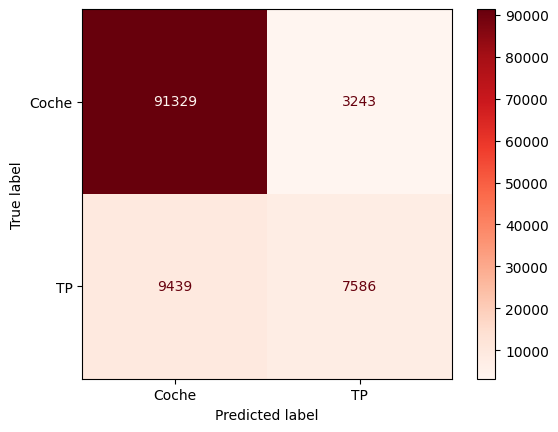

In [18]:
# Train-Test Split

# X = np.array(trips.drop(columns="Modo"))
# y = np.array( trips["Modo"] )
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train = np.array(trips_train.drop(columns="Modo"))
y_train = np.array(trips_train["Modo"])
X_test = np.array(trips_test.drop(columns="Modo"))
y_test = np.array(trips_test["Modo"])
# X_test = np.array(trips_train_p.drop(columns="Modo"))
# y_test = np.array(trips_train_p["Modo"])

# Model Training/Evaluation Framework

models = {}
# def train_evaluate(model,X=X,y=y,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,k=10,cross_validation=True):
def train_evaluate(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,k=10,cross_validation=False):

    model_name = type(model).__name__

    # El objetivo del cross-validation es evaluar el rendimiento del algoritmo de ML (rf in this case)
    # Pero no se usa luego para nada mas, el modelo que se entrena es otro, con otros datos

    # if cross_validation==True:
    #     print(model_name,"\n")
    #     print(f"{k}-FOLD CV\n")
    #     # k fold cross validation

    #     cv_scores = cross_val_score(model, X, y, cv=k,n_jobs=-1)

    #     # Scores on k-fold CV
    #     # Imprimir el score de cada ronda
    #     for i,score in zip(range(1,k+1),cv_scores):
    #         print(f"Round {i} score: {score}")
    #     print("")

    #     ax = sns.barplot(x = np.arange(1,11), y = np.array(cv_scores))
    #     ax.set(xlabel='Round', ylabel='Accuracy',title=f"{k}-fold CV Accuracy plot")
    #     plt.show()

    #     # scores avg on k-fold CV
    #     print(f"Score avg on {k}-fold CV: {cv_scores.mean()}\n")


    # Final Model
    print("\nFinal Model\n")
    # Model Training
    model = model.fit(X_train,y_train)
    print("Accuracy: ",model.score(X_test,y_test),"\n")
    # Prediction and Report
    y_pred = model.predict(X_test)
    print("Classification Report\n")
    print(metrics.classification_report(y_test, y_pred),"\n")

    print("Confusion Matrix\n")
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Reds")
    models[model_name] = model


    #pickle
    with open(os.path.join("models",f'{model_name}.pkl'), 'wb') as file:
        pkl.dump(model, file)

# Model Definiton and Evaluation

rf = RandomForestClassifier(n_estimators=20,random_state=random_state)
# rf = DecisionTreeClassifier(max_depth=5)
# rf = AdaBoostClassifier()
# rf = KNeighborsClassifier()
# rf = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),learning_rate=0.5, n_estimators=20,random_state=random_state)
train_evaluate(rf)

Elapsed time to compute the importances: 0.004 seconds


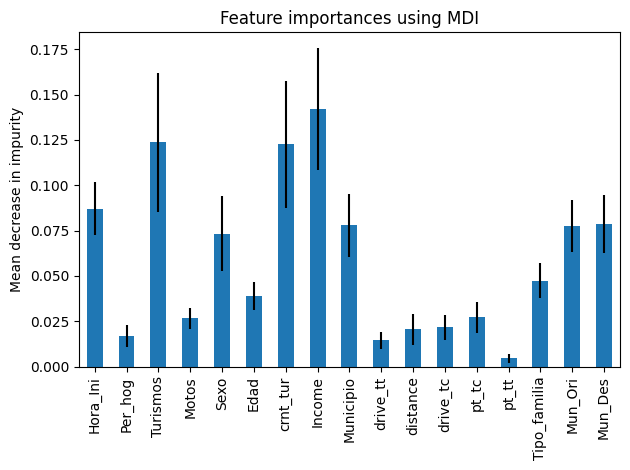

In [20]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
forest_importances = pd.Series(importances, index=trips_train.drop(columns='Modo').columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()